In this notebook the using the parameters found in "InitialClockParametersSearch.ipynb". An imepix3 readout clock drift is found to be none neglible. The clock affect is found and offset using signal processing algorithms. The global bunch structure is then graphed demonstrating triggerless sychcronisation with the LHC orbit clock

In [1]:
# Running parameters obtained in notebook: InitialClockParametersSearch.ipynb
ClockBin = 1.5625
LHCOrbitTimeInClockBins = 56909.083
LHCOrbitTime = LHCOrbitTimeInClockBins*ClockBin
delta = 15.96779293
BunchFrequency = (1/(ClockBin*1e-9))*1e-6/delta

In [2]:
%run ./OfflineTriggerFunc.py
%run ../../ClusterFunc.py
import pandas as pd 
import matplotlib.pyplot as plt 
from matplotlib.colors import LogNorm
import numpy as np
from IPython.display import clear_output

from scipy.signal import find_peaks

In [4]:
# In this case all particles are considered as we need as much statistics as possible in as short a time as possible
# All particle type contain some information about periodic structure of the field
# It is good to take a subsection of the total dataset as will be seen of fluxations in clock bin and precision may be significant when ToA Range is too large ToA
df = ReadTrackingFile("c:/shared/LandauData/MoEDAL/ProtonCollision/Clustered - 29_September_2018_04_29_e5_cleaned.txt - 09-08 06-11-2023_tracking.txt", 
                      nrows=10000000 
                     )[["Class","MinToA","Height","Energy", "Size", "PredTheta","PredPhi"]]

# Taking converting the ToAs to integers of Timepix3 clocks bins to remove any effect the periodicity of the TPX3 clock has on calculations
df["MinToA"] = ((df["MinToA"].values)//(ClockBin)).astype('int64')
df["OGMinToA"]= df["MinToA"].copy()

In [5]:
# Converting ToA values from float to integers allows us to minusing of larger numbers without rounding error
df["MinToA"] = np.int64(df["OGMinToA"])

# Mulitplying by a scaling factor gives a higher lever of of precision of values
Rescaling = np.int64(10000000)
df["MinToA"] = df["OGMinToA"] * Rescaling

LHCOrbitTimeInClockBins = 56909.083
LHCOrbitTimeInClockBins = np.int64(LHCOrbitTimeInClockBins * Rescaling)

#It's important to check that the integers haven't gotten too large causing overflow (minus values)
#Either reduce data set ToA range or reduce scaling factor if neccessary
df.tail()

,Class,MinToA,Height,Energy,Size,PredTheta,PredPhi,OGMinToA
9999995,5,3740270722110000000,47.281464,248.363371,14,0.751837,5.797753,374027072211
9999996,5,3740270968440000000,59.701154,376.326640,19,0.770480,4.728453,374027096844
9999997,4,3740271335210000000,37.163649,216.623942,14,0.865318,0.411027,374027133521
9999998,4,3740272390170000000,28.872881,275.266107,18,1.056087,2.368418,374027239017
9999999,5,3740272981180000000,73.996020,178.983211,5,0.387581,4.361261,374027298118


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


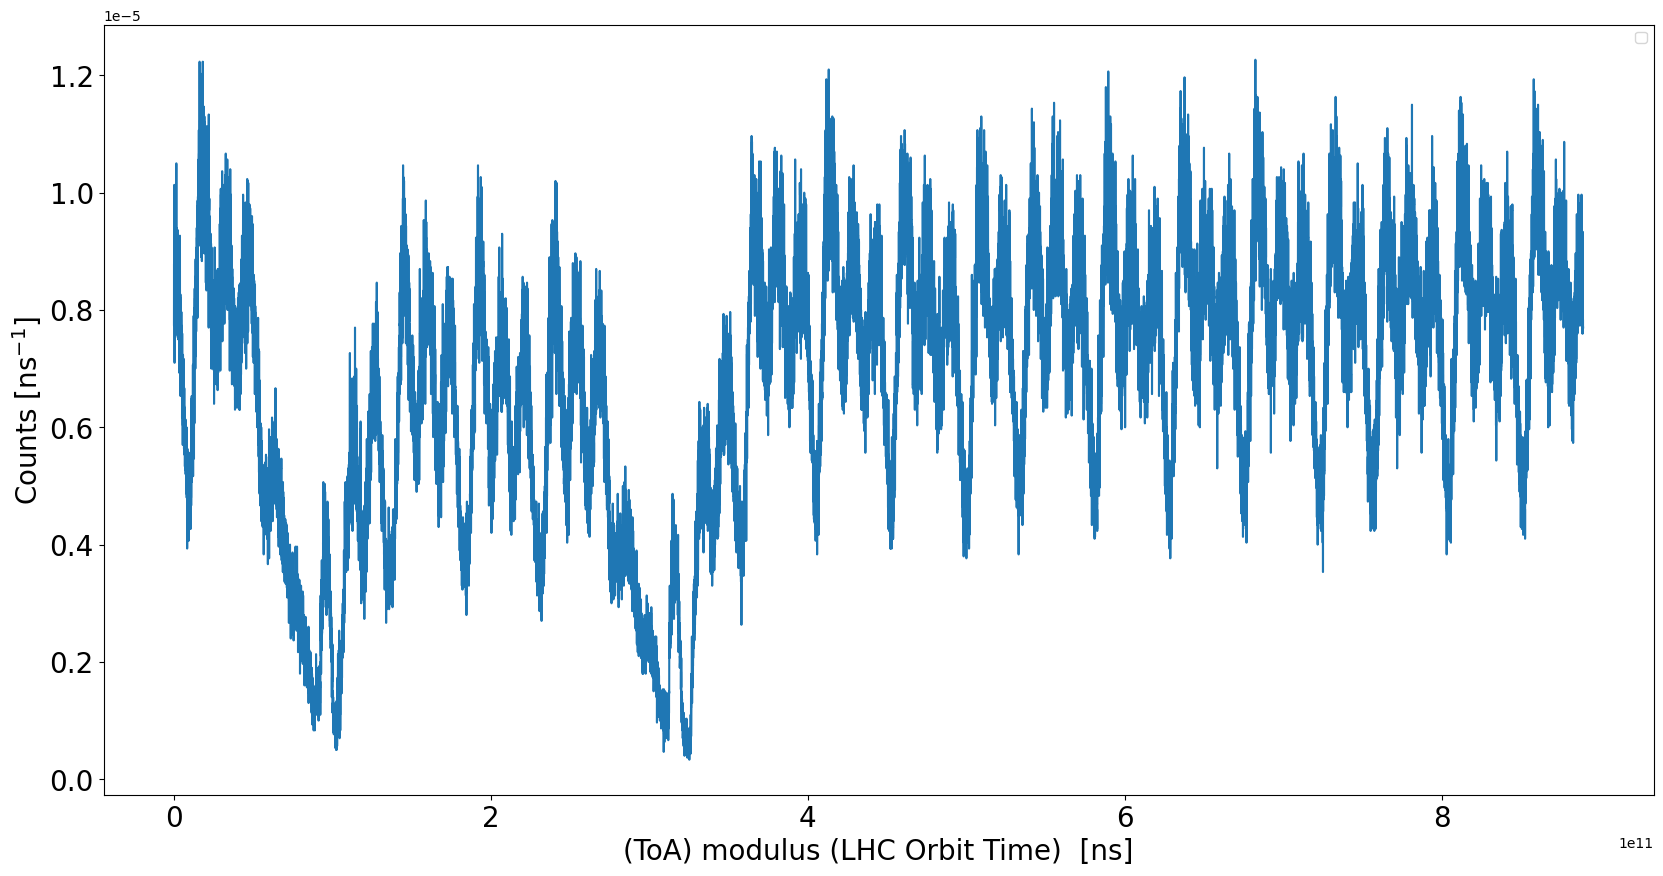

In [6]:
# Using the values achieved in InitialClockParametersSearch.ipynb
# The modulus of the LHC Orbit Time with the ToA values is graphed 
# Graph shows a clear structure but the structure doesn't correspond to the expected bunch structure
fig,ax =plt.subplots(figsize=(20,10))
y,x = np.histogram((df[df["Class"]==4]["MinToA"])%(LHCOrbitTimeInClockBins),bins=np.arange(0,LHCOrbitTimeInClockBins,3*Rescaling))
ax.step(x[1:]*ClockBin, y/(x[1]-x[0]))
ax.set_xlabel("(ToA) modulus (LHC Orbit Time)  [ns]", size=20)
ax.set_ylabel(r'Counts [ns$^{-1}$]', size=20)
ax.tick_params(labelsize=20)
ax.legend()

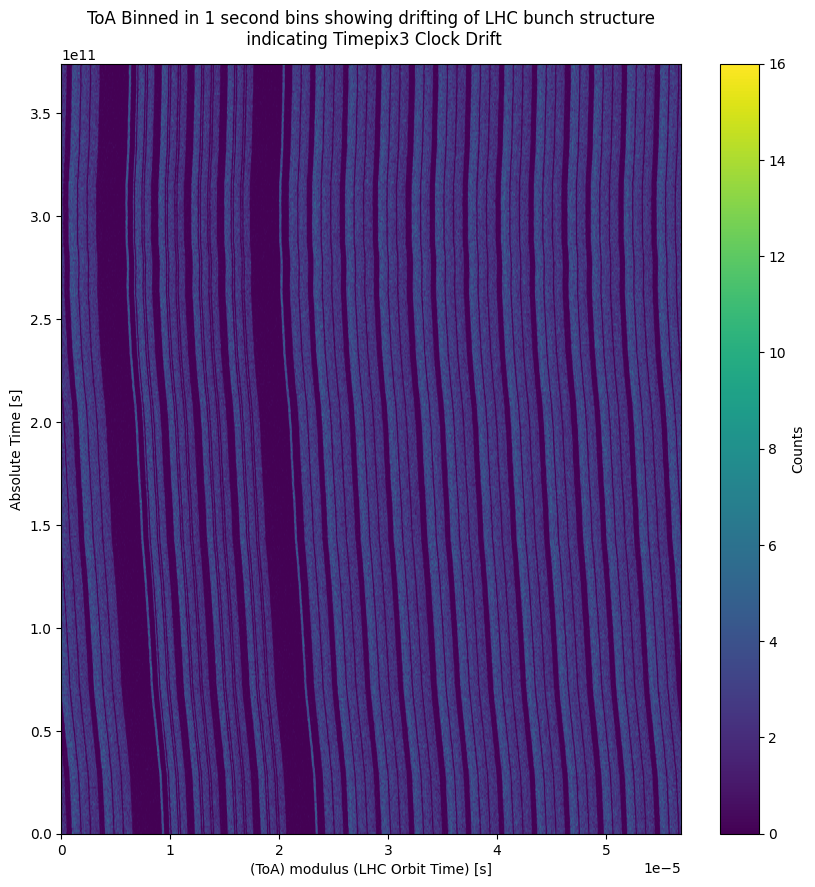

In [8]:
# By making the same graph as above but for multiple ToA bins we can a drifting bunch structure
# Each row of the graph below respresents the modulus of the LHC Orbit Time with the ToA values for given ToA range 
OrbitBins = np.arange(0,LHCOrbitTimeInClockBins,10*Rescaling).astype('int64')
TimeBins = np.arange(0,df["MinToA"].max(), 1e9*Rescaling).astype('int64')
fig = plt.figure(figsize=(10,10))
Values = GetBunchStructureEvolutionMatrix(df[df["Class"]==4]["MinToA"], LHCOrbitTimeInClockBins, OrbitBins, TimeBins)
plt.imshow(Values,aspect='auto',#norm=LogNorm(),
       extent=[OrbitBins.min()*1e-9/Rescaling, OrbitBins.max()*1e-9/Rescaling,TimeBins.min()/Rescaling,TimeBins.max()/Rescaling])
b = plt.colorbar()
b.ax.set_ylabel("Counts")
plt.title("ToA Binned in 1 second bins showing drifting of LHC bunch structure\n indicating Timepix3 Clock Drift",va='center')
plt.xlabel("(ToA) modulus (LHC Orbit Time) [s]")
plt.ylabel("Absolute Time [s]")
plt.show()

# This drifting structure is due to the fluxation of the length of a measured clock tick (1.5625 ns) in katerine readout 
# Possible to thermal fluxations
# This results in the a fluxation of the number of clock ticks per LHC oribit which should be constant 

In [ ]:
#

#This value can go up to 5e9 ns if the luminousity is low any higher and drift effect blurs bunch-bunch strcture
OGTimeBins = np.arange(0,df["MinToA"].max(), 1e9*Rescaling).astype('int64')

# This bin size works best when it is a factor of the bunch distance for p-p collisions is approx. 16 clock bins (25 ns)
OrbitBins = np.arange(0,LHCOrbitTimeInClockBins,4*Rescaling).astype('int64') 

# A good initial guess reduces the number of TotalIterations needed to reach stability
# It should be close to the LHC orbit time measured in the the first ToA bin 
# It good do a few test runs and with large number of TotalIteration but low SubIterations a good approximation and check the resulting LHCOrbitTimeVectors[0] 
# Using forward method
InitalGuess = 56909.0835
InitalLHCOrbitTimeVector = np.full(OGTimeBins.shape[0]-1,InitalGuess*Rescaling).astype('int64')


LHCOrbitTimeVector1,DeltaVector = FindClockDriftShiftCorrection(df["MinToA"], 
                                                                InitalLHCOrbitTimeVector.copy(),
                                                                 1e-8, # This Delta range in which the orbit time is search per iteraction LHCOrbitTime[i] +\-LHCOrbitTime[i]*Delta
                                                                 OrbitBins, OGTimeBins,
                                                                MaxShift=OrbitBins.shape[0]//10,
                                                                 TotalIterations=10,# The number of times the algorithm starts LHCOrbitVector[0] and iterate through the full matrix
                                                                 SubIterations=1, # Number of times the LHCOrbitVector is re-evaluated and LHCOribitVector[i] for each iteration
                                                                 method="forward")# Forward method uses the LHCOrbitTime[i] and an initial guess for LHCOrbitTime[i+1]

# The graph indicates a good Initial guess is 56909.082
plt.figure()
plt.plot(LHCOrbitTimeVectors1/Rescaling, label="Predicted Variation")
plt.axhline(InitalGuess, label="Initial Guess")
plt.xlabel("Measurement Time [ns]")
plt.ylabel("Predicted LHC Orbit Time [ClockBins]")
plt.show()

In [113]:
LHCOrbitTimeInClockBins//(4*Rescaling)

14227

In [127]:
%run ./OfflineTriggerFunc.py
#This value can go up to 5e9 ns if the luminousity is low any higher and drift effect blurs bunch-bunch strcture
TimeBins = np.arange(0,df["MinToA"].max(), 1e9*Rescaling).astype('int64')

# This bin size works best when it is a factor of the bunch distance for p-p collisions is approx. 16 clock bins (25 ns)
OrbitBins = np.arange(0,LHCOrbitTimeInClockBins,4*Rescaling).astype('int64') 
LHCOrbitTimeInitialGuess = 56909.0825
InitalLHCOrbitTimeVector = np.full(TimeBins.shape[0]-1,LHCOrbitTimeInitialGuess*Rescaling).astype('int64')

# The forward itertion finds approximation of the LHCOrbit vector 
# An approximation shape of the evolution of the measured LHC orbit time
# SubIteractions should be set such that it reduces the range of the prediction until it less the given precision 
# LHCOrbitTimeInitialGuess*Rescaling*Delta/(2^n) < O(1)
#   => 56909.082*10 000 000*1e-8/(2^16) = 0.0086 < 1 (15 could possible be used but 16 used for safety)
LHCOrbitTimeVector = FindClockDriftShiftCorrection(df["MinToA"], 
                                                    InitalLHCOrbitTimeVector.copy(),
                                                    3e-8, # This Delta range in which the orbit time is search per iteraction LHCOrbitTime[i] +\-LHCOrbitTime[i]*Delta
                                                    OrbitBins, TimeBins,
                                                    TotalIterations=5,# The number of times the algorithm starts LHCOrbitVector[0] and iterate through the full matrix
                                                    SubIterations=16, # Number of times the LHCOrbitVector is re-evaluated and LHCOribitVector[i] for each iteration
                                                    method="forward")# Forward method uses the LHCOrbitTime[i] and an initial guess for LHCOrbitTime[i+1]

# The central method increases stability of solution as it is possible to reduce Delta range as it assumed  the initial guesses are closer to the actual value in the initial prediction
LHCOrbitTimeVector = FindClockDriftShiftCorrection(df["MinToA"], LHCOrbitTimeVector.copy(), 1e-9, OrbitBins,
                                                    TimeBins,TotalIterations=30,SubIterations=10,
                                                    method="central")# central method uses the LHCOrbitTime[i] and an initial guess for LHCOrbitTime[i]

1/5:  

100%|████████████████████████████████████████████████████████████████████████████████| 373/373 [00:29<00:00, 12.47it/s]


Average Number Of iterations needed: 3.6327, Average Zero-Lag Cross-Correlation: 1.1105e-04
2/5:  

100%|████████████████████████████████████████████████████████████████████████████████| 373/373 [00:34<00:00, 10.88it/s]


Average Number Of iterations needed: 3.6327, Average Zero-Lag Cross-Correlation: 1.1105e-04
3/5:  

100%|████████████████████████████████████████████████████████████████████████████████| 373/373 [00:39<00:00,  9.41it/s]


Average Number Of iterations needed: 3.6327, Average Zero-Lag Cross-Correlation: 1.1105e-04
4/5:  

100%|████████████████████████████████████████████████████████████████████████████████| 373/373 [00:42<00:00,  8.79it/s]


Average Number Of iterations needed: 3.6327, Average Zero-Lag Cross-Correlation: 1.1105e-04
5/5:  

100%|████████████████████████████████████████████████████████████████████████████████| 373/373 [00:45<00:00,  8.12it/s]


Average Number Of iterations needed: 3.6327, Average Zero-Lag Cross-Correlation: 1.1105e-04
1/30:  

100%|████████████████████████████████████████████████████████████████████████████████| 373/373 [00:40<00:00,  9.13it/s]


Average Number Of iterations needed: 1.8418, Average Zero-Lag Cross-Correlation: 1.1101e-04
2/30:  

100%|████████████████████████████████████████████████████████████████████████████████| 373/373 [00:39<00:00,  9.36it/s]


Average Number Of iterations needed: 1.882, Average Zero-Lag Cross-Correlation: 1.1096e-04
3/30:  

100%|████████████████████████████████████████████████████████████████████████████████| 373/373 [00:39<00:00,  9.44it/s]


Average Number Of iterations needed: 1.8552, Average Zero-Lag Cross-Correlation: 1.1098e-04
4/30:  

100%|████████████████████████████████████████████████████████████████████████████████| 373/373 [00:34<00:00, 10.73it/s]


Average Number Of iterations needed: 1.8874, Average Zero-Lag Cross-Correlation: 1.1097e-04
5/30:  

100%|████████████████████████████████████████████████████████████████████████████████| 373/373 [00:25<00:00, 14.49it/s]


Average Number Of iterations needed: 1.9142, Average Zero-Lag Cross-Correlation: 1.1097e-04
6/30:  

100%|████████████████████████████████████████████████████████████████████████████████| 373/373 [00:27<00:00, 13.70it/s]


Average Number Of iterations needed: 1.8552, Average Zero-Lag Cross-Correlation: 1.1096e-04
7/30:  

100%|████████████████████████████████████████████████████████████████████████████████| 373/373 [00:28<00:00, 13.03it/s]


Average Number Of iterations needed: 2.0214, Average Zero-Lag Cross-Correlation: 1.1094e-04
8/30:  

100%|████████████████████████████████████████████████████████████████████████████████| 373/373 [00:28<00:00, 13.09it/s]


Average Number Of iterations needed: 2.0777, Average Zero-Lag Cross-Correlation: 1.1089e-04
9/30:  

100%|████████████████████████████████████████████████████████████████████████████████| 373/373 [00:24<00:00, 15.20it/s]


Average Number Of iterations needed: 2.0965, Average Zero-Lag Cross-Correlation: 1.1090e-04
10/30:  

100%|████████████████████████████████████████████████████████████████████████████████| 373/373 [00:25<00:00, 14.42it/s]


Average Number Of iterations needed: 2.059, Average Zero-Lag Cross-Correlation: 1.1090e-04
11/30:  

100%|████████████████████████████████████████████████████████████████████████████████| 373/373 [00:24<00:00, 15.36it/s]


Average Number Of iterations needed: 2.0858, Average Zero-Lag Cross-Correlation: 1.1089e-04
12/30:  

100%|████████████████████████████████████████████████████████████████████████████████| 373/373 [00:24<00:00, 15.18it/s]


Average Number Of iterations needed: 2.0429, Average Zero-Lag Cross-Correlation: 1.1094e-04
13/30:  

100%|████████████████████████████████████████████████████████████████████████████████| 373/373 [00:24<00:00, 15.21it/s]


Average Number Of iterations needed: 1.9115, Average Zero-Lag Cross-Correlation: 1.1098e-04
14/30:  

100%|████████████████████████████████████████████████████████████████████████████████| 373/373 [00:23<00:00, 15.76it/s]


Average Number Of iterations needed: 2.0697, Average Zero-Lag Cross-Correlation: 1.1093e-04
15/30:  

100%|████████████████████████████████████████████████████████████████████████████████| 373/373 [00:25<00:00, 14.85it/s]


Average Number Of iterations needed: 1.992, Average Zero-Lag Cross-Correlation: 1.1090e-04
16/30:  

100%|████████████████████████████████████████████████████████████████████████████████| 373/373 [00:23<00:00, 16.13it/s]


Average Number Of iterations needed: 1.9651, Average Zero-Lag Cross-Correlation: 1.1089e-04
17/30:  

100%|████████████████████████████████████████████████████████████████████████████████| 373/373 [00:23<00:00, 16.13it/s]


Average Number Of iterations needed: 2.0107, Average Zero-Lag Cross-Correlation: 1.1095e-04
18/30:  

100%|████████████████████████████████████████████████████████████████████████████████| 373/373 [00:23<00:00, 16.04it/s]


Average Number Of iterations needed: 2.008, Average Zero-Lag Cross-Correlation: 1.1089e-04
19/30:  

100%|████████████████████████████████████████████████████████████████████████████████| 373/373 [00:23<00:00, 16.17it/s]


Average Number Of iterations needed: 1.9946, Average Zero-Lag Cross-Correlation: 1.1089e-04
20/30:  

100%|████████████████████████████████████████████████████████████████████████████████| 373/373 [00:23<00:00, 16.14it/s]


Average Number Of iterations needed: 1.9357, Average Zero-Lag Cross-Correlation: 1.1087e-04
21/30:  

100%|████████████████████████████████████████████████████████████████████████████████| 373/373 [00:22<00:00, 16.49it/s]


Average Number Of iterations needed: 1.8177, Average Zero-Lag Cross-Correlation: 1.1086e-04
22/30:  

100%|████████████████████████████████████████████████████████████████████████████████| 373/373 [00:23<00:00, 16.08it/s]


Average Number Of iterations needed: 1.8338, Average Zero-Lag Cross-Correlation: 1.1087e-04
23/30:  

100%|████████████████████████████████████████████████████████████████████████████████| 373/373 [00:23<00:00, 15.65it/s]


Average Number Of iterations needed: 1.8445, Average Zero-Lag Cross-Correlation: 1.1085e-04
24/30:  

100%|████████████████████████████████████████████████████████████████████████████████| 373/373 [00:23<00:00, 16.22it/s]


Average Number Of iterations needed: 1.7775, Average Zero-Lag Cross-Correlation: 1.1087e-04
25/30:  

100%|████████████████████████████████████████████████████████████████████████████████| 373/373 [00:23<00:00, 16.21it/s]


Average Number Of iterations needed: 1.7748, Average Zero-Lag Cross-Correlation: 1.1086e-04
26/30:  

100%|████████████████████████████████████████████████████████████████████████████████| 373/373 [00:23<00:00, 15.97it/s]


Average Number Of iterations needed: 1.7962, Average Zero-Lag Cross-Correlation: 1.1086e-04
27/30:  

100%|████████████████████████████████████████████████████████████████████████████████| 373/373 [00:23<00:00, 16.20it/s]


Average Number Of iterations needed: 1.8365, Average Zero-Lag Cross-Correlation: 1.1083e-04
28/30:  

100%|████████████████████████████████████████████████████████████████████████████████| 373/373 [00:23<00:00, 16.15it/s]


Average Number Of iterations needed: 1.8633, Average Zero-Lag Cross-Correlation: 1.1084e-04
29/30:  

100%|████████████████████████████████████████████████████████████████████████████████| 373/373 [00:25<00:00, 14.62it/s]


Average Number Of iterations needed: 1.7614, Average Zero-Lag Cross-Correlation: 1.1083e-04
30/30:  

100%|████████████████████████████████████████████████████████████████████████████████| 373/373 [00:24<00:00, 15.06it/s]

Average Number Of iterations needed: 1.8123, Average Zero-Lag Cross-Correlation: 1.1085e-04


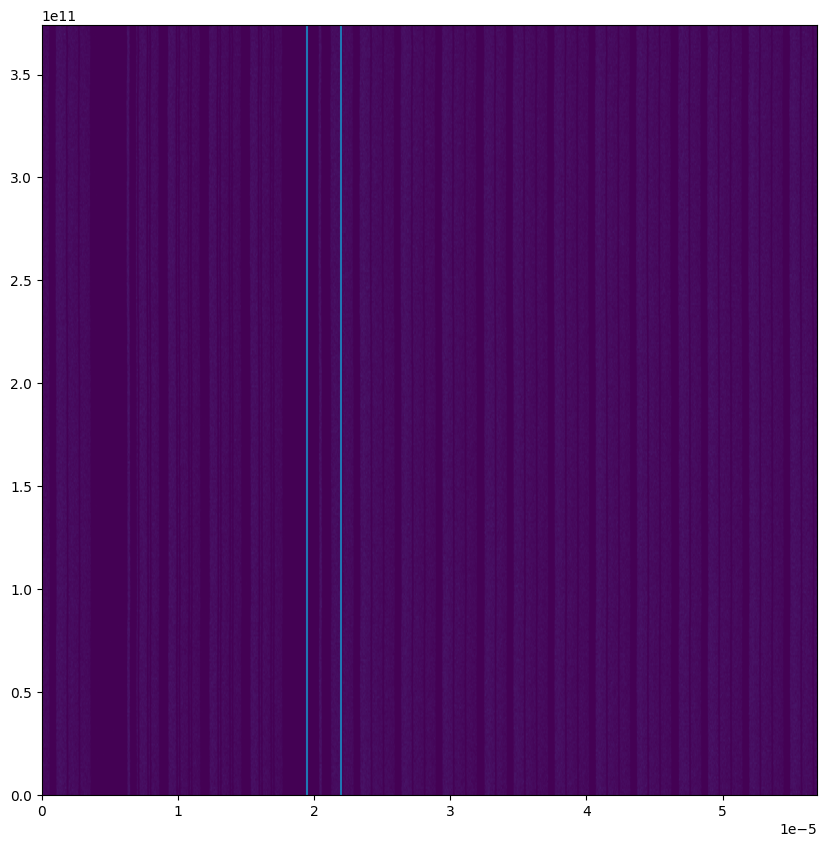

In [122]:
%run ./OfflineTriggerFunc.py
t = df[df["Class"]==4]["MinToA"]

OrbitBinNumber = LHCOrbitTimeInClockBins//(1*Rescaling) + 1
OrbitBins = np.linspace(0,LHCOrbitTimeInClockBins,OrbitBinNumber)
tt= np.int64(0)

fig = plt.figure(figsize=(10,10))
TemporalMatrix = GetBunchStructureEvolutionMatrixWithVariableOrbitTime(t, LHCOrbitTimeVector, OrbitBinNumber, TimeBins)
plt.axvline(1.95e-5)
plt.axvline(2.2e-5)
plt.imshow(TemporalMatrix,aspect='auto',#norm=LogNorm(),
       extent=[OrbitBins.min()*1e-9/Rescaling, OrbitBins.max()*1e-9/Rescaling,TimeBins.min()/Rescaling,TimeBins.max()/Rescaling])
plt.show()

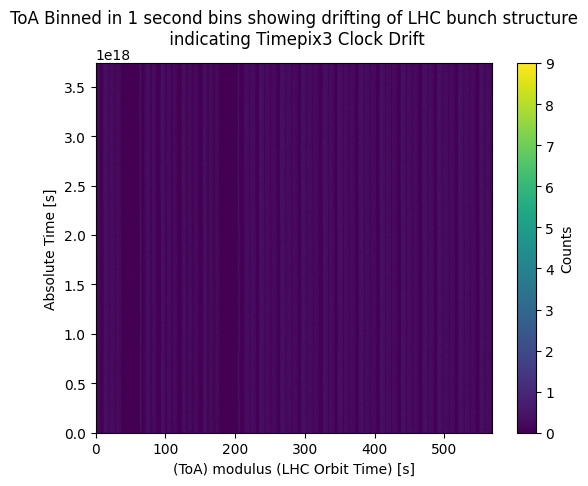

In [124]:
%run ./OfflineTriggerFunc.py
OrbitBins = np.arange(0,LHCOrbitTimeInClockBins,1*Rescaling).astype('int64')
t = df[df["Class"]==4]["MinToA"]
TemporalMatrix = GetBunchStructureEvolutionMatrixWithVariableOrbitTime(t, LHCOrbitTimeVector, OrbitBins, TimeBins)

plt.figure()
plt.imshow(TemporalMatrix,aspect='auto',
       extent=[OrbitBins.min()*1e-9, OrbitBins.max()*1e-9,TimeBins.min(),TimeBins.max()])
b = plt.colorbar()
b.ax.set_ylabel("Counts")
plt.title("ToA Binned in 1 second bins showing drifting of LHC bunch structure\n indicating Timepix3 Clock Drift",va='center')
plt.xlabel("(ToA) modulus (LHC Orbit Time) [s]")
plt.ylabel("Absolute Time [s]")
plt.show()

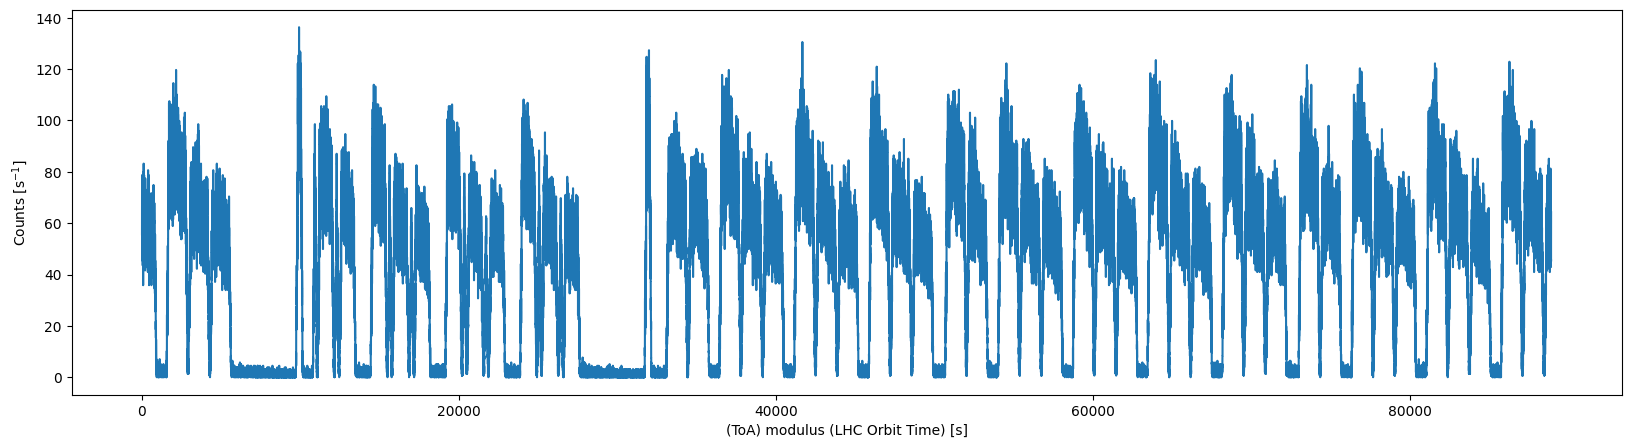

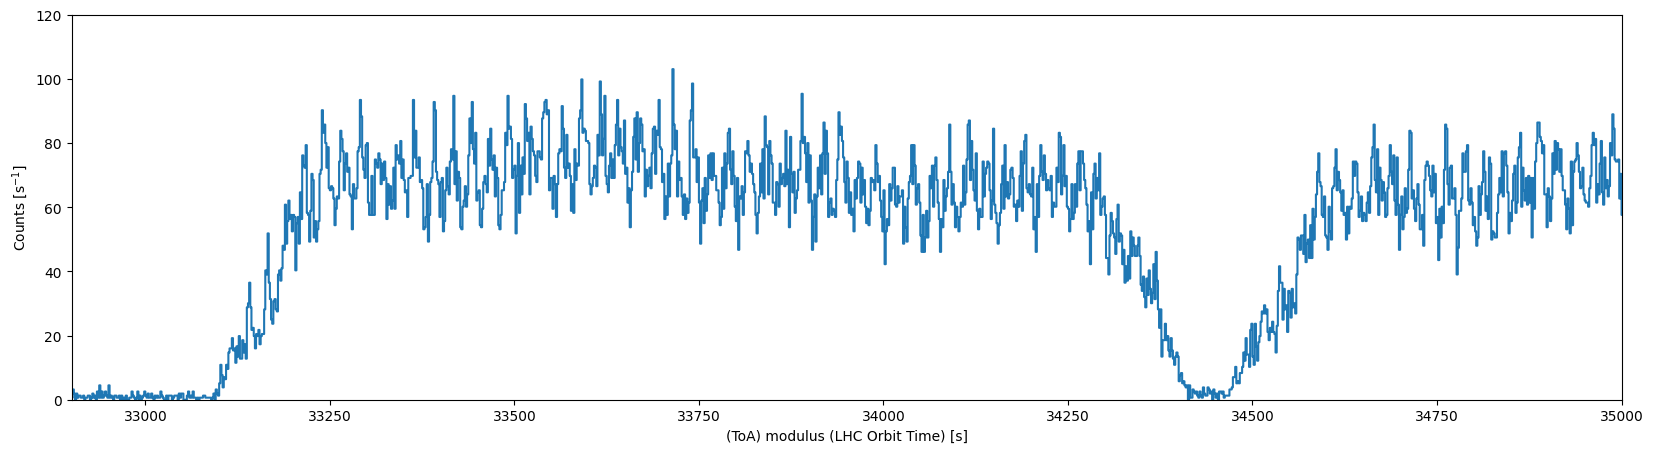

In [125]:
x = OrbitBins[1:]*ClockBin/Rescaling
y = TemporalMatrix.sum(axis=0)

plt.figure(figsize=(20,5))
plt.step(x,y/(x[1]-x[0]))
plt.xlabel("(ToA) modulus (LHC Orbit Time) [s]")
plt.ylabel(r"Counts [s$^{-1}$]")
plt.show()

x = OrbitBins[1:]*ClockBin/Rescaling
y = TemporalMatrix.sum(axis=0)

plt.figure(figsize=(20,5))
plt.step(x,y/(x[1]-x[0]))
plt.xlim(32900,35000)
plt.xlabel("(ToA) modulus (LHC Orbit Time) [s]")
plt.ylabel(r"Counts [s$^{-1}$]")
plt.ylim(0,120)
plt.show()

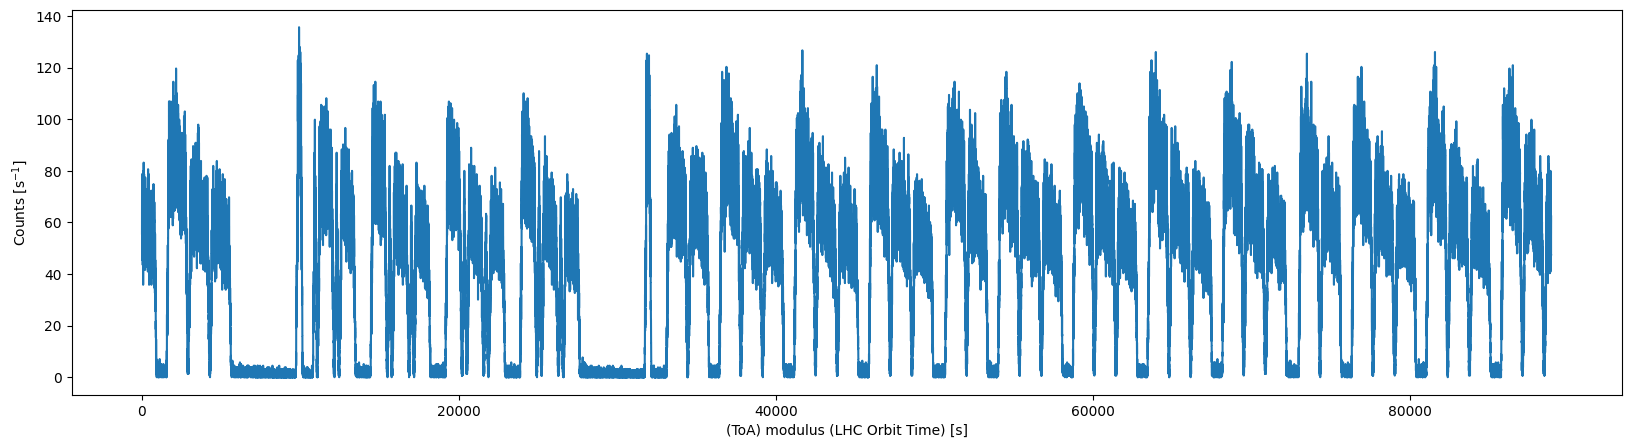

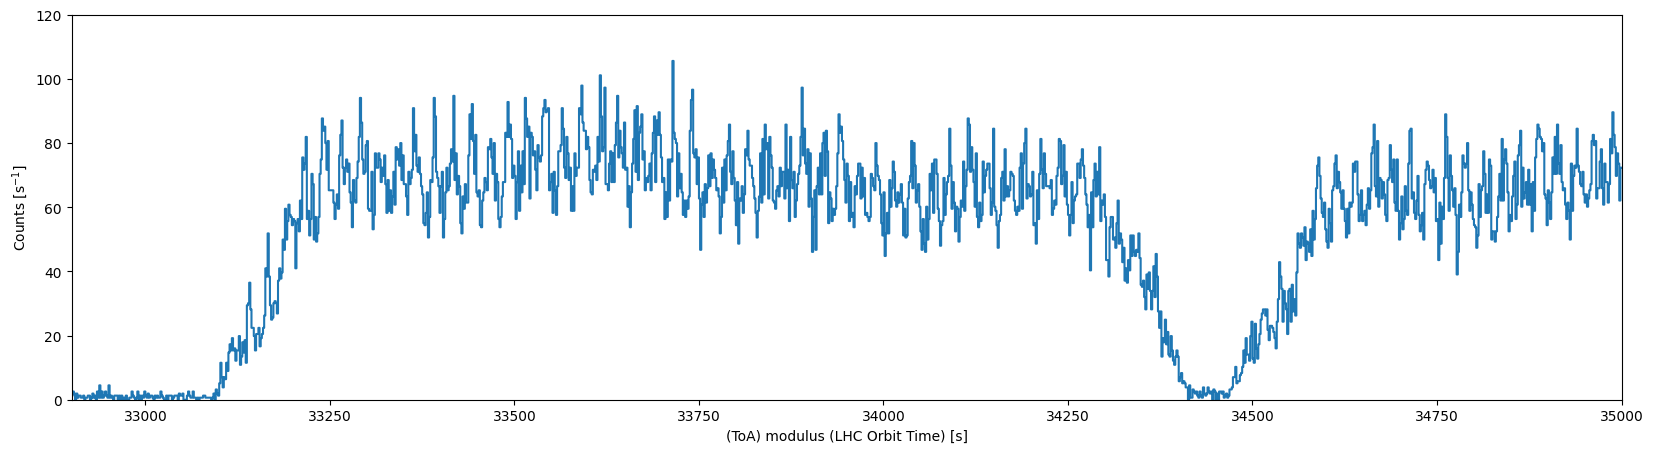

In [123]:
x = OrbitBins[1:]*ClockBin/Rescaling
y = TemporalMatrix.sum(axis=0)

plt.figure(figsize=(20,5))
plt.step(x,y/(x[1]-x[0]))
plt.xlabel("(ToA) modulus (LHC Orbit Time) [s]")
plt.ylabel(r"Counts [s$^{-1}$]")
plt.show()

x = OrbitBins[1:]*ClockBin/Rescaling
y = TemporalMatrix.sum(axis=0)

plt.figure(figsize=(20,5))
plt.step(x,y/(x[1]-x[0]))
plt.xlim(32900,35000)
plt.xlabel("(ToA) modulus (LHC Orbit Time) [s]")
plt.ylabel(r"Counts [s$^{-1}$]")
plt.ylim(0,120)
plt.show()

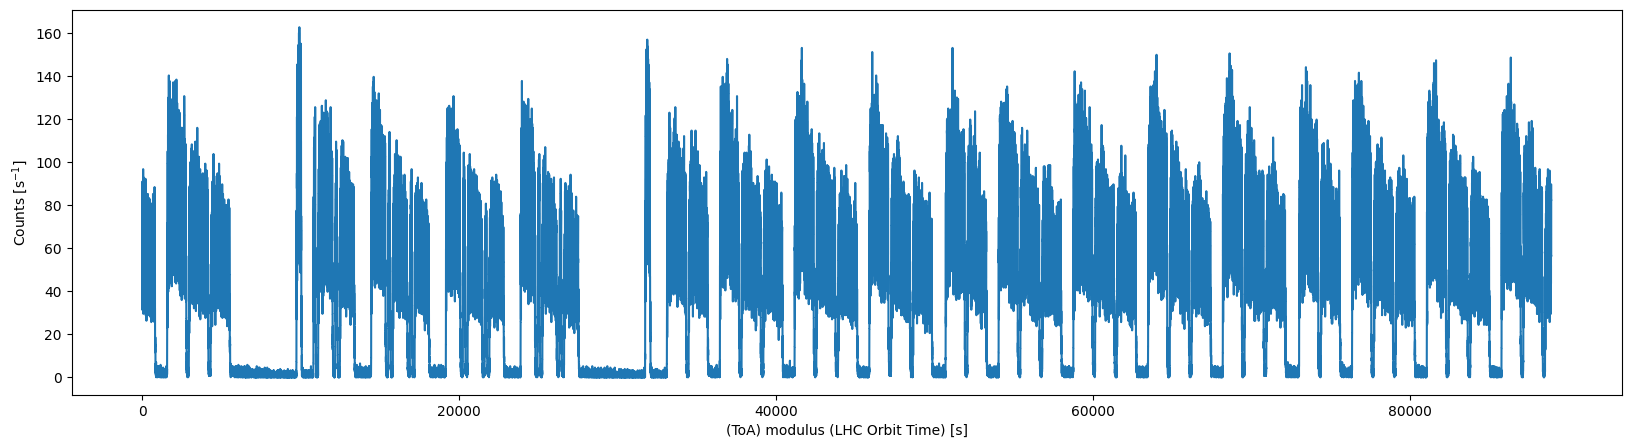

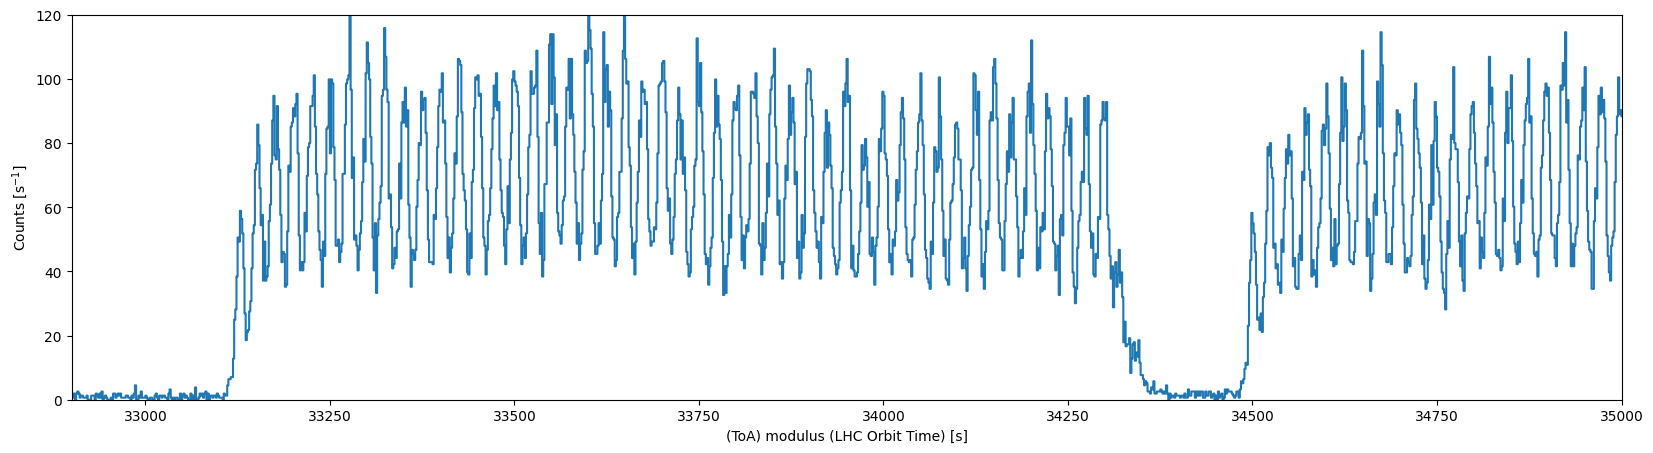

In [102]:
x = OrbitBins[1:]*ClockBin/Rescaling
y = TemporalMatrix.sum(axis=0)

plt.figure(figsize=(20,5))
plt.step(x,y/(x[1]-x[0]))
plt.xlabel("(ToA) modulus (LHC Orbit Time) [s]")
plt.ylabel(r"Counts [s$^{-1}$]")
plt.show()

x = OrbitBins[1:]*ClockBin/Rescaling
y = TemporalMatrix.sum(axis=0)

plt.figure(figsize=(20,5))
plt.step(x,y/(x[1]-x[0]))
plt.xlim(32900,35000)
plt.xlabel("(ToA) modulus (LHC Orbit Time) [s]")
plt.ylabel(r"Counts [s$^{-1}$]")
plt.ylim(0,120)
plt.show()

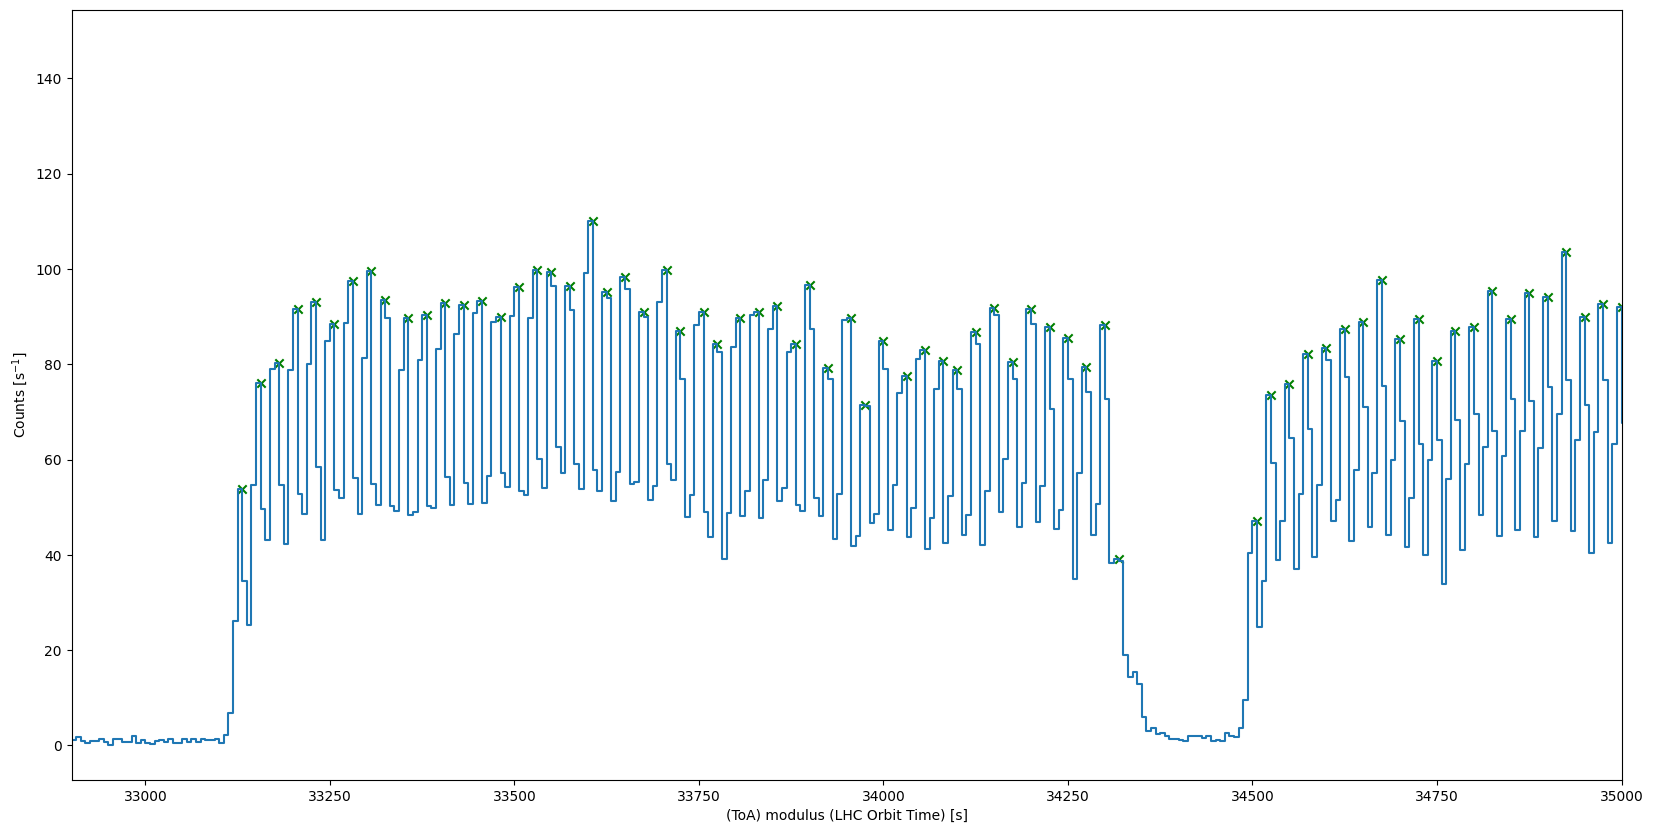

In [103]:
# The previous graph is redone but this increasing the histogram bin size to reduce noise during peak detection
OrbitBins = np.arange(0,LHCOrbitTimeInClockBins,4*Rescaling).astype('int64')
t = df[df["Class"]==4]["MinToA"]
TemporalMatrix = GetBunchStructureEvolutionMatrixWithVariableOrbitTime(t, LHCOrbitTimeVector, OrbitBins, TimeBins)

x = OrbitBins[1:]*ClockBin/Rescaling
y = TemporalMatrix.sum(axis=0)

plt.figure(figsize=(20,10))
peaks, _ = find_peaks(y/(x[1]-x[0]),height=20)
plt.scatter(x[peaks], y[peaks]/(x[1]-x[0]),marker='x',color='g')
plt.step(x,y/(x[1]-x[0]))
plt.xlabel("(ToA) modulus (LHC Orbit Time) [s]")
plt.ylabel(r"Counts [s$^{-1}$]")
plt.xlim(32900,35000)
plt.show()

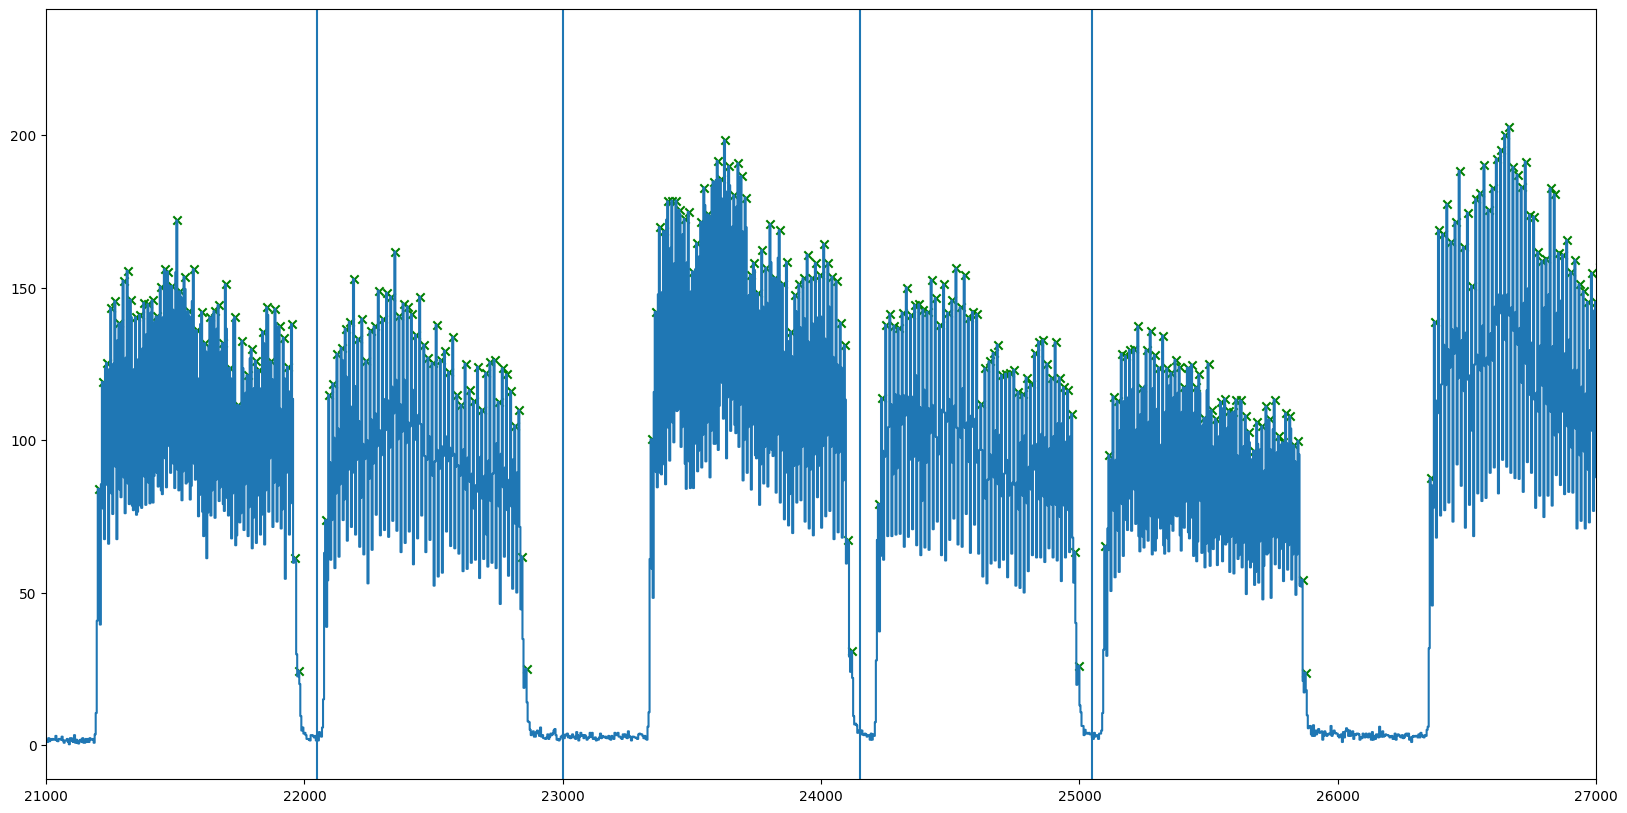

In [104]:
x = OrbitBins[1:]/Rescaling
y = TemporalMatrix.sum(axis=0)

plt.figure(figsize=(20,10))
plt.step(x,y/(x[1]-x[0]))

# Globally a slightly lower number of peaks detected possible due to failure of the peak finding algorithm
peaks, _ = find_peaks(y/(x[1]-x[0]),height=20)
plt.scatter(x[peaks], y[peaks]/(x[1]-x[0]),marker='x',color='g')
plt.xlim(21000,27000)
plt.axvline(22050)
plt.axvline(23000)
plt.axvline(24150)
plt.axvline(25050)
plt.show()

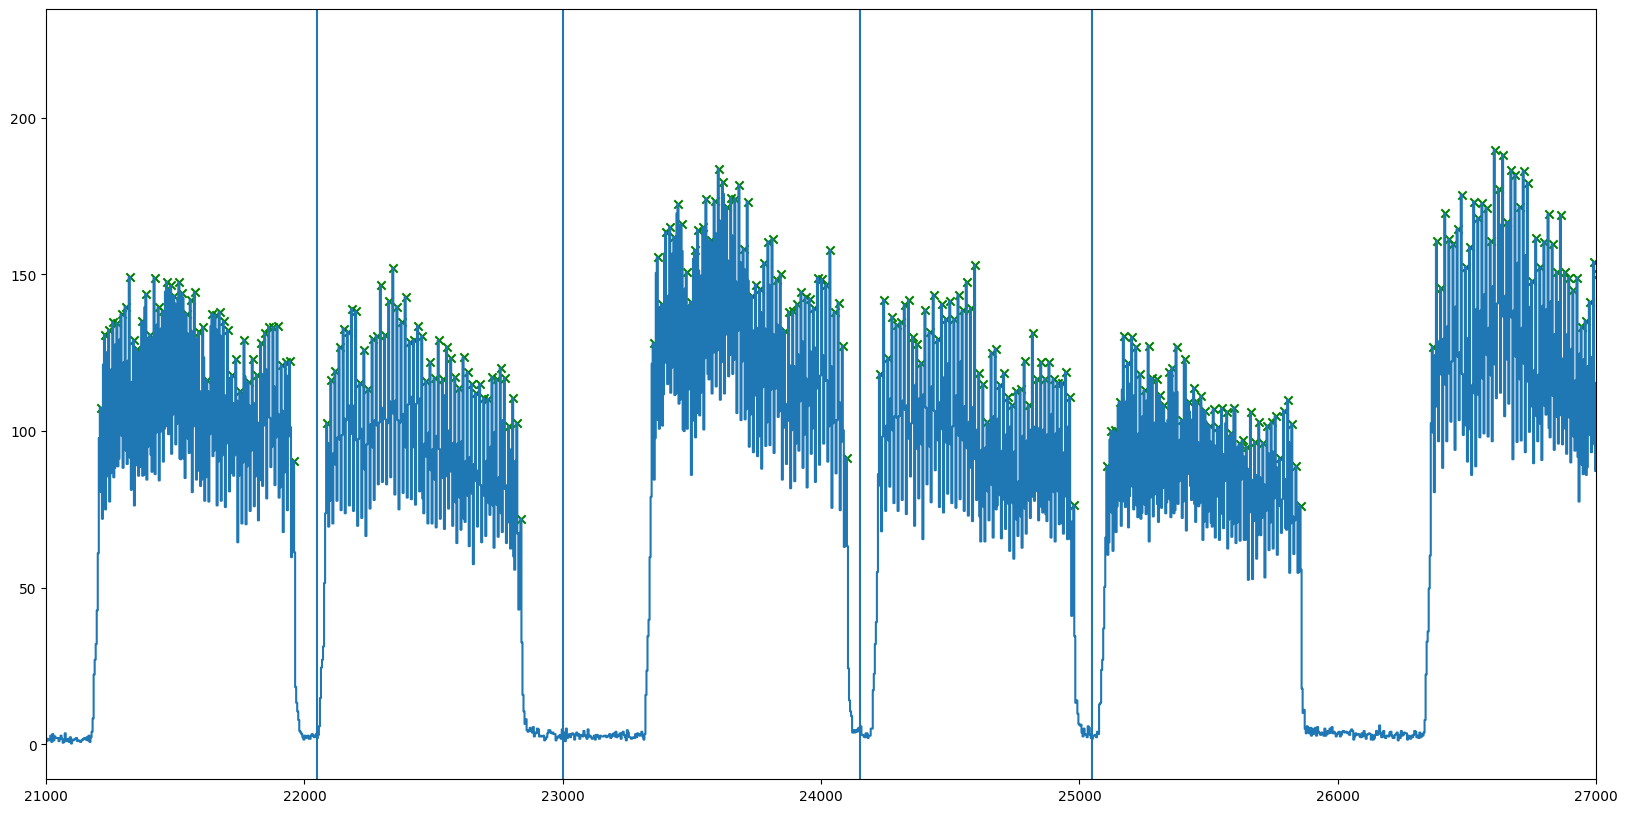

In [70]:
x = OrbitBins[1:]/Rescaling
y = TemporalMatrix.sum(axis=0)

plt.figure(figsize=(20,10))
plt.step(x,y/(x[1]-x[0]))

# Globally a slightly lower number of peaks detected possible due to failure of the peak finding algorithm
peaks, _ = find_peaks(y/(x[1]-x[0]),height=20)
plt.scatter(x[peaks], y[peaks]/(x[1]-x[0]),marker='x',color='g')
plt.xlim(21000,27000)
plt.axvline(22050)
plt.axvline(23000)
plt.axvline(24150)
plt.axvline(25050)
plt.show()

Using the peak prediction algorithm it can be shown that all bunch trains have 48 bunches in the above graph has 48 bunches as expected

In [105]:
peaks, _ = find_peaks(y[(x>(21000)) & (x<(22050))]/(x[1]-x[0]),height=20)
peaks.shape[0]

50

In [106]:
peaks, _ = find_peaks(y[(x>(22000)) & (x<(23000))]/(x[1]-x[0]),height=20)
peaks.shape[0]

50

In [107]:
peaks, _ = find_peaks(y[(x>(23000)) & (x<(24150))]/(x[1]-x[0]),height=20)
peaks.shape[0]

50

In [108]:
peaks, _ = find_peaks(y[(x>(24150)) & (x<(25050))]/(x[1]-x[0]),height=20)
peaks.shape[0]

50

In [109]:
peaks, _ = find_peaks(y[(x>(25050)) & (x<(26000))]/(x[1]-x[0]),height=20)
peaks.shape[0]

50

In [76]:
peaks, _ = find_peaks(y/(x[1]-x[0]),height=20)
peaks.shape[0]

2338

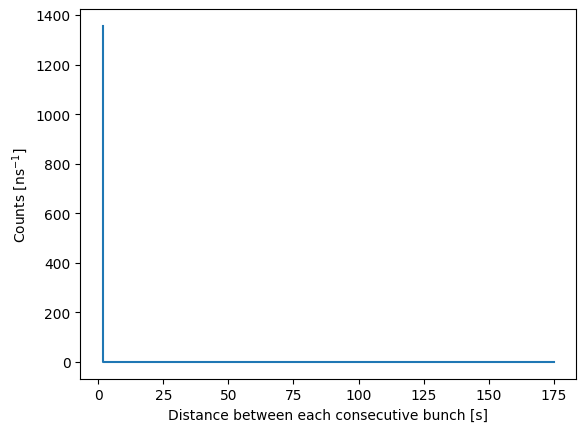

In [186]:
px = x[1:][peaks]*1e-9
plt.figure()
y,x = np.histogram(px[1:] - px[:-1],bins=np.linspace(0,175,100))
plt.step(x[1:],y/(x[1:]-x[:-1]))
plt.xlabel("Distance between each consecutive bunch [s]")
plt.ylabel(r"Counts [ns$^{-1}$]")
plt.show()